In [3]:
# Import necessary packages
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Introduction & Problem

> Hospital readmission after an admitted patient is discharged is a high priority for hospitals. In total Hospital Readmissions are one of the most costly episodes to treat, costing Medicare about 26 billion annually, with about 17 billion consisting of avoidable trips after discharge. 

> The health care burden of hospitalized patients with diabetes (1 and 2) is substantial and only growing. As of today, around 9% of Americans have diabetes or prediabetes, according to a recent CDC report. 

> A better understanding of the factors that lead to hospital readmissions could help decision makers understand potential ways to reduce early readmissions (within 30 days) and provide more efficient care.

> Classification problem : We focused our project on attempting to predict whether a discharged diabetic patient will be readmitted into a hospital within 30 days (Target = 1)  or not (Target = 0).


# Part 1 : EDA

In [4]:
df = pd.read_csv('diabetic_data.csv')

In [5]:
df.shape

(101766, 50)

## Mapping Admission, Discharge & Admission Source Types

In [6]:
# importing mapping .csv
mapping = pd.read_csv('IDs_mapping.csv')

In [7]:
admission_type_map = mapping[:8]
discharge_type_map = mapping[10:40]
admission_source_map = mapping[42:]
discharge_type_map.columns = ['discharge_disposition_id','description']
admission_source_map.columns = ['admission_source_id', 'description']

In [8]:
discharge_type_map.head()

,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...


## Data Cleaning

In [9]:
# Removing discharge codes 11 (Expired), 13-14 (Hospice care), 19-21 (Expired)
terminally_ill = [11,13,14,19,21]
df = df[~df['discharge_disposition_id'].isin(terminally_ill)]

In [10]:
# Removing NaN & Not mapped values
df = df[~df['admission_type_id'].isin([6,8])]
df = df[~df['admission_source_id'].isin([17,20])]
df = df[~df['discharge_disposition_id'].isin([25])]

In [11]:
# Replacing values into 0 for no change and 1 for change 

df.change = df.change.replace(to_replace = 'Ch', value = 1)
df.change = df.change.replace(to_replace = 'No', value = 0)
df.gender = df.gender.replace(to_replace = 'Female', value = 1)
df.gender = df.gender.replace(to_replace = 'Male', value = 0)

#change our diabetes values 
dm = {'Yes': 1, 'No': 0}
df['diabetesMed'] = df['diabetesMed'].replace(to_replace = (dm), value=None)

In [12]:
# Identifying duplicate patients

duplicates = df[df.patient_nbr.isin(df.patient_nbr[df.patient_nbr.duplicated()])].sort_values(by = 'patient_nbr')
duplicates[['patient_nbr', 'number_inpatient', 'readmitted']].head()

,patient_nbr,number_inpatient,readmitted
4780,135,1,>30
4267,135,0,<30
23623,1152,1,>30
24642,1152,2,NO
14180,1152,1,>30


In [13]:
# Dropping 3 rows where gender is unknown/invalid

df.drop(df[df.gender == 'Unknown/Invalid'].index, inplace=True)

In [14]:
df.gender.value_counts()

1    48534
0    41447
Name: gender, dtype: int64

In [15]:
# Number of repeated visits for patients
(df.patient_nbr.value_counts() > 1).sum()

14921

In [16]:
# Dropping identification columns
df.drop('patient_nbr', axis = 1, inplace= True) # Dropping identification column
df.drop('payer_code', axis = 1, inplace= True) # Dropping Insurance information

In [17]:
# Exploring medication values to drop columns containing no information based on value counts
medication = ['max_glu_serum', 'A1Cresult','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

meds_df = df[medication].apply(pd.Series.value_counts)
meds_df

,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
>200,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>300,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>7,NaN,3564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>8,NaN,7463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Down,NaN,NaN,526.0,42.0,10.0,1.0,179.0,NaN,483.0,494.0,...,NaN,NaN,NaN,NaN,10750.0,6.0,NaN,NaN,NaN,NaN
No,NaN,NaN,71756.0,88523.0,89310.0,89907.0,85174.0,89980.0,78807.0,80524.0,...,89979.0,89952.0,89981.0,89981.0,41606.0,89291.0,89968.0,89980.0,89979.0,89980.0
None,89668.0,74238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Norm,46.0,4716.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steady,NaN,NaN,16737.0,1312.0,639.0,67.0,4328.0,1.0,10028.0,8241.0,...,2.0,28.0,NaN,NaN,27515.0,677.0,13.0,1.0,2.0,1.0
Up,NaN,NaN,962.0,104.0,22.0,6.0,300.0,NaN,663.0,722.0,...,NaN,1.0,NaN,NaN,10110.0,7.0,NaN,NaN,NaN,NaN


In [18]:
# Dropping encounter_id & medication with less than 2 varying values
df.drop(['encounter_id','metformin-pioglitazone','metformin-rosiglitazone',
         'glimepiride-pioglitazone','troglitazone','acetohexamide','examide','citoglipton'], axis =1, inplace= True)

In [19]:
# Replacing '?' Values into appropriate values

df.weight = df.weight.replace(to_replace='?', value='Not specified') # Not specified for Weight
df.race = df.race.replace(to_replace='?', value='Not Specified') # 'Not specified for Race
df.medical_specialty = df.medical_specialty.replace(to_replace='?', value='Not specified') # 'Not specified' for Med.Specialty
df.max_glu_serum = df.max_glu_serum.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.max_glu_serum = df.max_glu_serum.replace(to_replace='Norm', value = 'Normal') # To make it more readable
df.A1Cresult = df.A1Cresult.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.A1Cresult = df.A1Cresult.replace(to_replace='Norm', value = 'Normal') # To make it more readable

## Target Variable: Setting Early (within 30 days) readmission to '1' 

In [20]:
# Checking for NA values in target variable
df.readmitted.isna().sum() 

0

>We are trying to predict patient early readmissions (within 30 days), therefore we combine readmissions over 30 days in the same group as non readmitted patients.

In [21]:
# Combining > 30 days before readmission and No as one category
df.readmitted = df.readmitted.replace(to_replace='>30', value='0')
df.readmitted = df.readmitted.replace(to_replace='NO', value='0')
df.readmitted = df.readmitted.replace(to_replace='<30', value='1')

In [22]:
# Changing Object type columns to int because values are 0 or 1
df.readmitted = df.readmitted.astype(int)
df.gender = df.gender.astype(int)

## Verifying if Class Imbalance exists for target variable

> The target variable identifying whether a patient was readmitted early (within 30 days) is imbalanced, 11% of patients were readmitted within 30 days.
To combat imbalanced data, we opted to **downsample** the 'No' category. Downsampling will be done in Part 2. This will allow us to achieve a balance ratio closer to 1:1 and improve our binary classification predictions.

In [23]:
# Checking for class imbalance
df.readmitted.value_counts(normalize = True)

0    0.88592
1    0.11408
Name: readmitted, dtype: float64

##  Webscraping ICD-9 Codes & their descriptions

> In health care, diagnosis codes are used as a tool to group and identify diseases, disorders, symptoms, poisonings, adverse effects of drugs and chemicals, injuries and other reasons for patient encounters. Diagnostic coding is the translation of written descriptions of diseases, illnesses and injuries into codes from a particular classification. In medical classification, diagnosis codes are used as part of the clinical coding process alongside intervention codes. International Statistical Classification of Diseases and Related Health Problems (ICD) is one of the most widely used classification systems for diagnosis coding as it allows comparability and use of mortality and morbidity data.

>ICD codes in this dataset refer to ICD-9 codes.


In [24]:
# Page to scrape
page = f'http://www.icd9data.com/2008/Volume1/default.htm'

# Make a get request to retrieve the page
html_page = requests.get(page)

# Pass the page content to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 
pretty_soup = soup.prettify()

In [25]:
# Beautiful soup to retrieve ICD codes & description
icd9 = [li.text.split('  ') for li in soup.find('ul').find_all('li')]

In [26]:
# Converting diagnosis codes into dataframe
icd9_df = pd.DataFrame(icd9, columns = ['icd9_range', 'diagnosis_desc'])

# Creating a range of values for icd9 codes
icd9_df['icd9_range'] = list(icd9_df['icd9_range'].apply(lambda x: x.split('-')))

In [27]:
icd9_df

,icd9_range,diagnosis_desc
0,"[001, 139]",Infectious And Parasitic Diseases
1,"[140, 239]",Neoplasms
2,"[240, 279]","Endocrine, Nutritional And Metabolic Diseases,..."
3,"[280, 289]",Diseases Of The Blood And Blood-Forming Organs
4,"[290, 319]",Mental Disorders
5,"[320, 389]",Diseases Of The Nervous System And Sense Organs
6,"[390, 459]",Diseases Of The Circulatory System
7,"[460, 519]",Diseases Of The Respiratory System
8,"[520, 579]",Diseases Of The Digestive System
9,"[580, 629]",Diseases Of The Genitourinary System


### Mapping diagnosis codes to grouped ICD-9 codes

In [28]:
# Function to map diagnosis codes to the description of group disease they belong to

def icd_map(code):
    
    # Special characters mapping
    if str(code)[0] == 'V':
        return icd9_df.diagnosis_desc.loc[17]
    elif str(code)[0] == 'E':
        return icd9_df.diagnosis_desc.loc[18]
    
    # Replacing question mark into No diagnosis
    elif str(code)[0] == '?':
        return 'No diagnosis'
    
    # Numerical codes mapping
    else:
        code = round(float(code),0)
        for i in range(0,19):
            if code in range(int(icd9_df.icd9_range[i][0]),int(icd9_df.icd9_range[i][1])+1):
                return icd9_df.diagnosis_desc[i]

In [29]:
# Feature Engineering - Mapping to ICD9 codes and merging to initial dataframe
df['diag1_desc'] = df['diag_1'].apply(icd_map)
df['diag2_desc'] = df['diag_2'].apply(icd_map)
df['diag3_desc'] = df['diag_3'].apply(icd_map)

In [30]:
# Diagnosis table
diagnosis = df[['diag1_desc','diag2_desc','diag3_desc']].apply(pd.Series.value_counts)
diagnosis

,diag1_desc,diag2_desc,diag3_desc
"Complications Of Pregnancy, Childbirth, And The Puerperium",663,409,292
Congential Anomalies,43,95,87
Diseases Of The Blood And Blood-Forming Organs,1016,2566,2202
Diseases Of The Circulatory System,26911,27728,26549
Diseases Of The Digestive System,8130,3478,3142
Diseases Of The Genitourinary System,4564,7169,5592
Diseases Of The Musculoskeletal System And Connective Tissue,4417,1603,1716
Diseases Of The Nervous System And Sense Organs,1100,1157,1562
Diseases Of The Respiratory System,8903,8782,5825
Diseases Of The Skin And Subcutaneous Tissue,2257,3264,2213


In [31]:
# Dropping ICD9 code columns as they are now grouped
df = df.drop(['diag_1','diag_2','diag_3'],axis =1)

In [32]:
df.shape

(89981, 40)

### Grouping drugs by drug class

>To reduce dimensionality, we grouped 16 medications into 5 drug families.

> biguanides : The term biguanide refers to a group of oral type 2 diabetes drugs that work by preventing the production of glucose in the liver, improving the body's sensitivity towards insulin and reducing the amount of sugar absorbed by the intestines.

> meglitinides : The glinides are a class of drug which have a similar response as sulphonylureas but act for a shorter time. Meglitinides are prescribed to be taken by people with type 2 diabetes within half an hour before eating. As the drugs act for a shorter period than sulphonylureas, the side effects of hypoglycemia and weight gain have a smaller likelihood.

> sulfonylureas : Sulphonylureas are the class of antidiabetic drug for type 2 diabetes that tends to include those drugs which end in ‘ide’. They work by increasing the amount of insulin the pancreas produces and increasing the working effectiveness of insulin. The mode of action of sulphonylureas means that hypoglycemia and weight gain can be relatively common side effects.

> thiazolidinediones : Thiazolidinediones, also known as glitazones, are a medication for type 2 diabetes which help to improve insulin sensitivity and have been found to help decrease triglyceride levels.

> alpha_glucosidase_inhibitors : Alpha-glucosidase inhibitors, such as acarbose (marketed as Precose or Glucobay) or miglitol (branded as Glyset) are drugs for type 2 diabetes which slow down the digestion of carbohydrates in the small intestine and therefore can help to reduce after meal blood sugar levels.

> insulins : Insulin is a hormone which helps to regulate blood sugar. A number of different types of insulin are available as medication, with some insulins acting for as long as a day and others acting for only a few hours.

source : https://www.diabetes.co.uk/diabetes-medication/

In [33]:
# create a dictionary with the different medication families for each diabetes drug so that
# we can manipulate these columns and narrow down the amount of features we are using
drug_classes = {'biguanides' : ['metformin', 'glyburide-metformin', 'glipizide-metformin'], 
                'meglitinides':['repaglinide','nateglinide'], 
                'sulfonylureas': ['chlorpropamide','glimepiride','glipizide', 'glyburide','tolbutamide', 'tolazamide','glyburide-metformin', 'glipizide-metformin'], 
                'thiazolidinediones': ['pioglitazone','rosiglitazone'], 
                'alpha_glucosidase_inhibitors': ['acarbose', 'miglitol'], 
                'insulins': ['insulin']}

#Create dictionarty with our keys as the data found in our medication columns and the values of each key as a Bool  
replaced = {'Steady': True, 'Up': True, 'Down': True, 'No': False} 


#Iterate through and classify our patients as either on our off each medication, by changing our values for 'Down, Up, Steady' to True and our value for 'No' as False
for column in df.iloc[:,18:34]:
    df[column] = df[column].replace(to_replace = replaced, value = None)

In [34]:
# need to create new dummy variable column for each drug class family and 
# have it equal true if the individual is on a medication for any drug within that family

df['biguanides'] = df[(df['metformin'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1)
df['biguanides'] = df['biguanides'].fillna(False) 


# create a conditional statement
df['meglitinides'] = df[(df['repaglinide'] == True) | (df['nateglinide'] == True)].any(axis=1)
df['meglitinides'] = df['meglitinides'].fillna(False) 


df['sulfonylureas'] = df[(df['chlorpropamide'] == True) | (df['glimepiride'] == True) | (df['glipizide']==True) | (df['glyburide'] == True) | (df['tolbutamide'] == True) | (df['tolazamide'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1) 
df['sulfonylureas'] = df['sulfonylureas'].fillna(False)                                                            
                                            

df['thiazolidinediones'] = df[(df['pioglitazone'] == True) | (df['rosiglitazone'] == True) | (df['glipizide'] == True)].any(axis=1)
df['thiazolidinediones'] = df['thiazolidinediones'].fillna(False)     


df['alpha_glucosidase_inhibitors'] = df[(df['acarbose'] == True) | (df['miglitol'] == True)].any(axis=1)
df['alpha_glucosidase_inhibitors'] = df['alpha_glucosidase_inhibitors'].fillna(False)


df['insulins'] = df[(df['insulin'] == True)].any(axis=1) 
df['insulins'] = df['insulins'].fillna(False)  


df = df.drop(df.iloc[:,18:34], axis =1)


### Medical specialties: Retaining 10 medical specialties

> To reduce dimensionality of medical specialties, we have grouped all the medical specialties who had less than 500 patients into one category called "Other".

In [35]:
# Identifying Top 10 medical specialties, will group all other specialties into 'Other' category
df.medical_specialty.value_counts() > 500

Not specified                            True
InternalMedicine                         True
Emergency/Trauma                         True
Family/GeneralPractice                   True
Cardiology                               True
Surgery-General                          True
Orthopedics                              True
Nephrology                               True
Radiologist                              True
Orthopedics-Reconstructive               True
Psychiatry                               True
Pulmonology                              True
Surgery-Cardiovascular/Thoracic          True
ObstetricsandGynecology                  True
Urology                                  True
Surgery-Vascular                        False
Gastroenterology                        False
Surgery-Neuro                           False
PhysicalMedicineandRehabilitation       False
Oncology                                False
Pediatrics                              False
Neurology                         

In [36]:
#create a list for our top 10 professions which will allow us to group all of our other values into "Other" 
medprofessions = ['Not specified', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Nephrology', 'Radiologist', 'Orthopedics-Reconstructive']


#replace all values in medical_specialty column that are not considered the most common with the value 'Other'
df.loc[~df.medical_specialty.isin(medprofessions), 'medical_specialty'] = 'Other'

### Correlation Heatmap

> There is no correlation over |0.8| between numerical variables.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text yticklabel objects>)

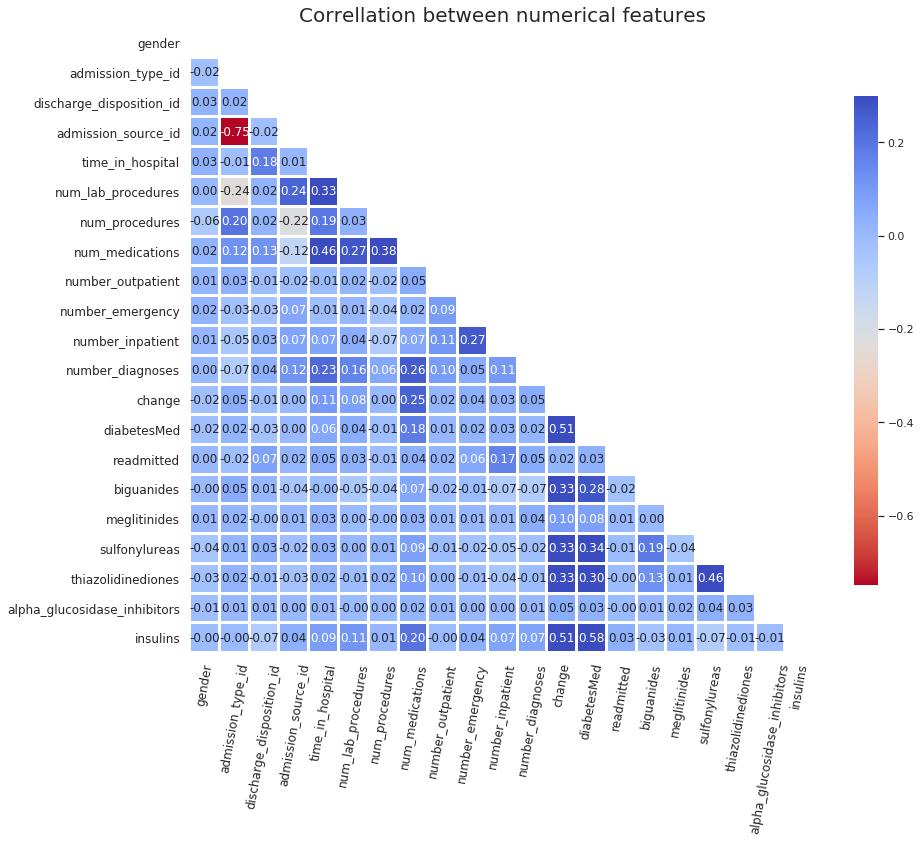

In [37]:
# Correlation heatmap
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

plt.figure(figsize=(14,12))

sns.heatmap(df.corr(),mask=mask, annot= True, vmax=.3,cmap = 'coolwarm_r', square=True, fmt='.2f',
            linewidths=2, cbar_kws={"shrink": 0.75})
plt.title('Correllation between numerical features', size = 20)
plt.xticks(rotation=80, size = 12)
plt.yticks(size = 12)

In [38]:
df1 = df.copy(deep=True)

### Combining 3 diagnosis into one indicator

> Function to identify which diseases were present for each patient by encoding each of disease classifications as dummy columns.

In [39]:
def make_col_diagnosis(diagnosis):
    df1[diagnosis] = df1[(df1['diag1_desc'] == diagnosis) | (df1['diag2_desc'] == diagnosis)
                       | (df1['diag3_desc'] == diagnosis)].any(axis=1)
    df1[diagnosis] = df1[diagnosis].fillna(False)

In [40]:
for diag in diagnosis.T.columns.tolist():
    make_col_diagnosis(diag)

In [41]:
df1 = df1.drop(['diag1_desc','diag2_desc','diag3_desc'], axis = 1)

In [42]:
df1 = df1.reset_index()
df1 = df1.drop('index', axis =1) 

### Exploring distribution of age 

In [43]:
age_dict = df1.age.value_counts().to_dict()
age_dict = collections.OrderedDict(sorted(age_dict.items()))
age_dict

OrderedDict([('[0-10)', 146),
             ('[10-20)', 640),
             ('[20-30)', 1526),
             ('[30-40)', 3415),
             ('[40-50)', 8697),
             ('[50-60)', 15550),
             ('[60-70)', 20157),
             ('[70-80)', 22689),
             ('[80-90)', 14822),
             ('[90-100)', 2339)])

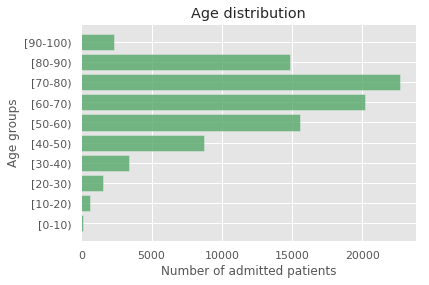

<Figure size 864x576 with 0 Axes>

In [44]:
# Horizontal barplot
plt.style.use('ggplot')
plt.barh(np.arange(10), list(age_dict.values()), align='center', alpha=0.8, color = 'g')
plt.yticks(np.arange(10), age_dict.keys())
plt.xlabel('Number of admitted patients')
plt.ylabel('Age groups')
plt.title('Age distribution')
plt.figure(figsize=(12,8))
plt.show()

### Exploring distribution of numerical variables

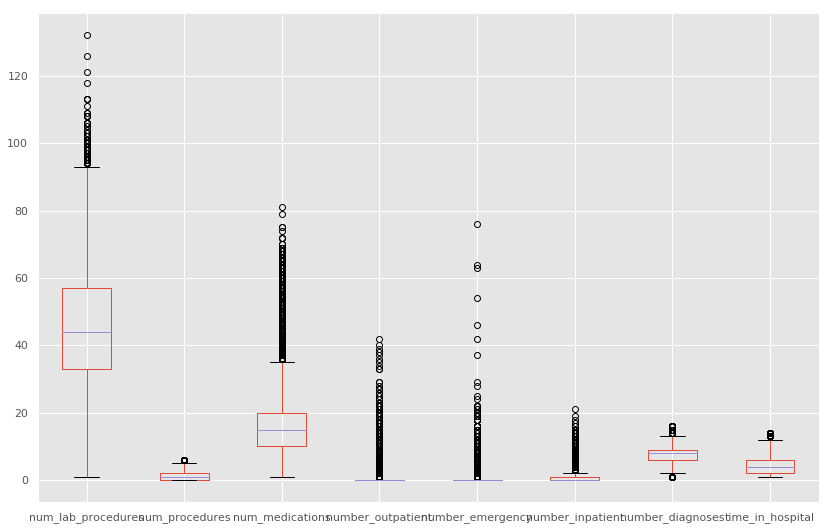

In [45]:
df1[['num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses','time_in_hospital']].boxplot(figsize = (14,9))

### Dimensionality reduction: PCA limited to 6 components

In [46]:
X_scale = ['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [47]:
#import Standard Scaler and use it to scale our continuous variables 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_for_x = scaler.fit(df1[X_scale])
x = scaled_for_x.transform(df1[X_scale]) 

#using PCA to reduce dimensionality of our continuous variables 
from sklearn.decomposition import PCA

pca = PCA(n_components = 6)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5','PCA_6'])

#examine the variance explained by our Principal Components
print(pca.explained_variance_ratio_)


[0.25388298 0.17179902 0.12493312 0.11906943 0.10244657 0.09167577]


/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pacman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [48]:
#add our new PCA columns to our dataframe
df1 = pd.concat([principalDf, df1], axis=1) 
#drop our old continuous variable columns
df1.drop(X_scale, axis = 1, inplace=True)

## Dummy Variables Encoding for Categorical Data

>  Label encoding for categorical data not changed manually: 'age','race', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'medical_specialty', 'max_glu_serum', 'A1Cresult'

In [49]:
# Creating Dummy variables for all the following categorical columns

X_dummies = ['age','race', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'medical_specialty', 'max_glu_serum', 'A1Cresult']

dummies_1 = pd.get_dummies(df1['age'], prefix = 'age', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_2 = pd.get_dummies(df1['race'],prefix = 'race', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_3 = pd.get_dummies(df1['weight'],prefix = 'weight', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_4 = pd.get_dummies(df1['admission_type_id'],prefix = 'admission_type', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_5 = pd.get_dummies(df1['discharge_disposition_id'],prefix = 'discharge_disposition', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_6 = pd.get_dummies(df1['admission_source_id'],prefix = 'admission_source', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_7 = pd.get_dummies(df1['medical_specialty'],prefix = 'medical_specialty', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_8 = pd.get_dummies(df1['max_glu_serum'],prefix = 'max_glu_serum', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_9 = pd.get_dummies(df1['A1Cresult'],prefix = 'A1Cresult', drop_first = True).rename(columns=lambda x: '_' + str(x))

In [50]:
# Adding dummy columns to Dataframe
dummies = [dummies_1,dummies_2,dummies_3,dummies_4,dummies_5,dummies_6,dummies_7,dummies_8,dummies_9]
for dummy in dummies:
    df1 = pd.concat([df1, dummy], axis=1)

In [51]:
# Dropping dummies encoded columns
df1.drop(X_dummies, axis =1, inplace=True)

In [52]:
df1.shape

(89981, 109)

# Part 2: Modeling

### Setting X & y

In [53]:
y = df1.readmitted
X = df1.drop(['readmitted'], axis = 1)

In [56]:
y.shape

(89981,)

In [57]:
X.shape

(89981, 108)

### Under sampling y & Setting Training sets for X and y

In [58]:
np.random.seed(0)

In [59]:
from imblearn.under_sampling import RandomUnderSampler

In [60]:
X_resampled, y_resampled = RandomUnderSampler().fit_sample(X,y)

In [61]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = RandomUnderSampler().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

0    79716
1    10265
Name: readmitted, dtype: int64
1    10265
0    10265
dtype: int64


In [62]:
#split our data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = .20) 

### ROC-AUC curve function

In [1]:
def create_roc_auc(model):
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    y_score_train = model.predict_proba(X_train)[:,1]
    fpr_t, tpr_t, thresholds_t = roc_curve(y_train, y_score_train)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC_test: {}'.format(auc(fpr, tpr)))
    print('AUC_train: {}'.format(auc(fpr_t, tpr_t)))
    
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='coral',
             lw=lw, label='ROC curve - Test')
    plt.plot(fpr_t, tpr_t, color='deepskyblue',
             lw=lw, label='ROC curve - Train')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

## Baseline Model: Logistic Regression

In [2]:
from sklearn.linear_model import LogisticRegression
#instantiate logreg object
logreg = LogisticRegression(fit_intercept= False)

#fit our model with our training data
model_log = logreg.fit(X_train, y_train) 

#predict our target variable 
y_train_hat = model_log.predict(X_train)
y_test_hat = model_log.predict(X_test) 

NameError: name 'X_train' is not defined

In [ ]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

In [ ]:
confusion_matrix(y_test, y_test_hat)

In [ ]:
# Residuals
resid = pd.DataFrame(abs(y_train - y_train_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  accurate

In [ ]:
create_roc_auc(model_log)

### Tuning Logistic Regression

> Tuning logistic regression predictions with parameter grid:

> Results are similar to base model, best parameters are mostly the default values. Best parameters C = 1, penalty score based on L1 - Lasso. (default is L2), number of iterations = 100. **Lasso** shrinks some coefficients close to 0 or to 0 by penalizing the cost function.

In [69]:
# Parameter grid

param_grid = {"max_iter" : [100,200,500],
    "penalty": ['l1','l2'],
    "C" : [1,10]}

In [70]:
# Grid search & fitting logistic regression

logreg_cv = LogisticRegression()
dt_grid_search = GridSearchCV(logreg_cv, param_grid = param_grid, cv = 3, return_train_score=True, scoring = 'accuracy')
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2'], 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [71]:
# Best parameters

dt_grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l1'}

In [72]:
#predict our target variable

y_train_hat = dt_grid_search.predict(X_train)
y_test_hat = dt_grid_search.predict(X_test)

In [73]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.6179371651242085
accuracy test score: 0.6144666341938626
recall score for test: 0.5356622998544396
recall score for train: 0.5414431984397855
precision score for test: 0.638150289017341
precision score for train: 0.6386772106398274


In [74]:
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_log = pd.DataFrame(classification_report(y_train, y_train_hat, output_dict = True))
class_rep_log

[[1419  626]
 [ 957 1104]]


,0,1,micro avg,macro avg,weighted avg
f1-score,0.645260,0.586054,0.617937,0.615657,0.615686
precision,0.602704,0.638677,0.617937,0.620690,0.620673
recall,0.694282,0.541443,0.617937,0.617863,0.617937
support,8220.000000,8204.000000,16424.000000,16424.000000,16424.000000


In [75]:
# Classification Report for Testing data

class_rep_log = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_log

,0,1,micro avg,macro avg,weighted avg
f1-score,0.641936,0.582432,0.614467,0.612184,0.612068
precision,0.597222,0.638150,0.614467,0.617686,0.617766
recall,0.693888,0.535662,0.614467,0.614775,0.614467
support,2045.000000,2061.000000,4106.000000,4106.000000,4106.000000


### KNN:  K-Nearest Neighbors

> Using GridSearch and comparing K = 5 and K = 100, our KNN model is optimized using K = 100. Results are poor and computationally expensive to optimize. KNN is not ideal for the size of our data.

In [76]:
# Fitting KNN with K = 100

param_grid_knn = {'n_neighbors' : [5, 100]}
knn = KNN()
grid_knn = GridSearchCV(knn, param_grid = param_grid_knn)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [77]:
# Best K
grid_knn.best_params_

{'n_neighbors': 100}

In [78]:
knn_best = KNN(n_neighbors=100)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [79]:
#predict our target variable 
y_train_hat = knn_best.predict(X_train)
y_test_hat = knn_best.predict(X_test) 

In [80]:
# Confusion Matrix
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_tr = pd.DataFrame(classification_report(y_train, y_train_hat, output_dict = True))
class_rep_tr

[[1465  580]
 [1076  985]]


,0,1,micro avg,macro avg,weighted avg
f1-score,0.651811,0.559028,0.610874,0.605420,0.605465
precision,0.590232,0.644141,0.610874,0.617186,0.617160
recall,0.727737,0.493784,0.610874,0.610760,0.610874
support,8220.000000,8204.000000,16424.000000,16424.000000,16424.000000


In [81]:
# Classification Report for Testing data

class_rep_tst = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_tst

,0,1,micro avg,macro avg,weighted avg
f1-score,0.638901,0.543298,0.596688,0.591100,0.590913
precision,0.576545,0.629393,0.596688,0.602969,0.603072
recall,0.716381,0.477923,0.596688,0.597152,0.596688
support,2045.000000,2061.000000,4106.000000,4106.000000,4106.000000


In [82]:
# Residuals
resid = pd.DataFrame(abs(y_train - y_train_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  ~58% accurate

0    0.610874
1    0.389126
Name: residual, dtype: float64

In [83]:
resid = pd.DataFrame(abs(y_test - y_test_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  ~58% accurate

0    0.596688
1    0.403312
Name: residual, dtype: float64

AUC_test: 0.6426384039841083
AUC_train: 0.6620307760382746


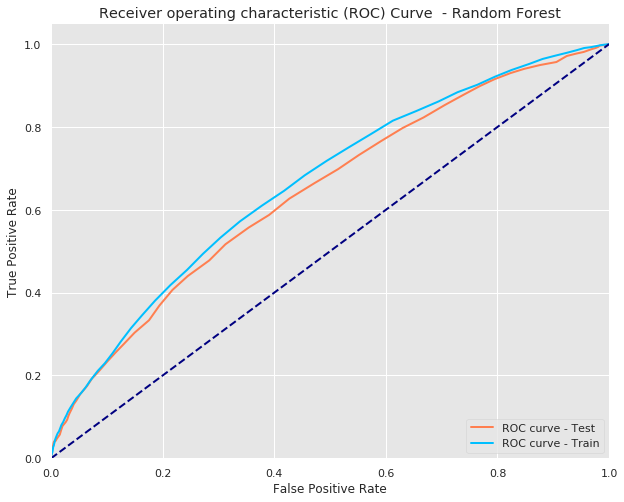

In [84]:
create_roc_auc(knn_best)

### Random Forest
> Most important features include:
- Number of inpatient visits of the patient in the year preceding the encounter
- Discharge disposition code # 22 : Discharged/transferred to another rehab fac including rehab units of a hospital
- Number of emergency visits of the patient within the year preceding the encounter
- Number of lab tests performed during the encounter
- Time in hospital (measured in days)
- Number of procedures (Number of procedures (other than lab tests) performed during the encounter)
- Discharge disposition code # 3 : Discharged/transferred to SNF (skilled nursing facility)

> After GridSearch, parameters used are:
- criterion = 'entropy'
- max_depth = 10
- n_estimators = 100
- min_sample_split = 2 (Default)

In [85]:
# Grid Search
param_grid_rf = {'criterion' : ['gini','entropy'],
                 'max_depth': [5,10],
                 'n_estimators': [100, 115, 150]}

In [86]:
# Instantiating Random Forest classifier 
forest = RandomForestClassifier()
grid_rf = GridSearchCV(forest, param_grid = param_grid_rf) # default cv = 3
grid_rf.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'n_estimators': [100, 115, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 115}

In [88]:
best_rf = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 150)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
# Predicting values 

y_train_hat = best_rf.predict(X_train)
y_test_hat = best_rf.predict(X_test) 

In [90]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(18,27))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), list(X.columns)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

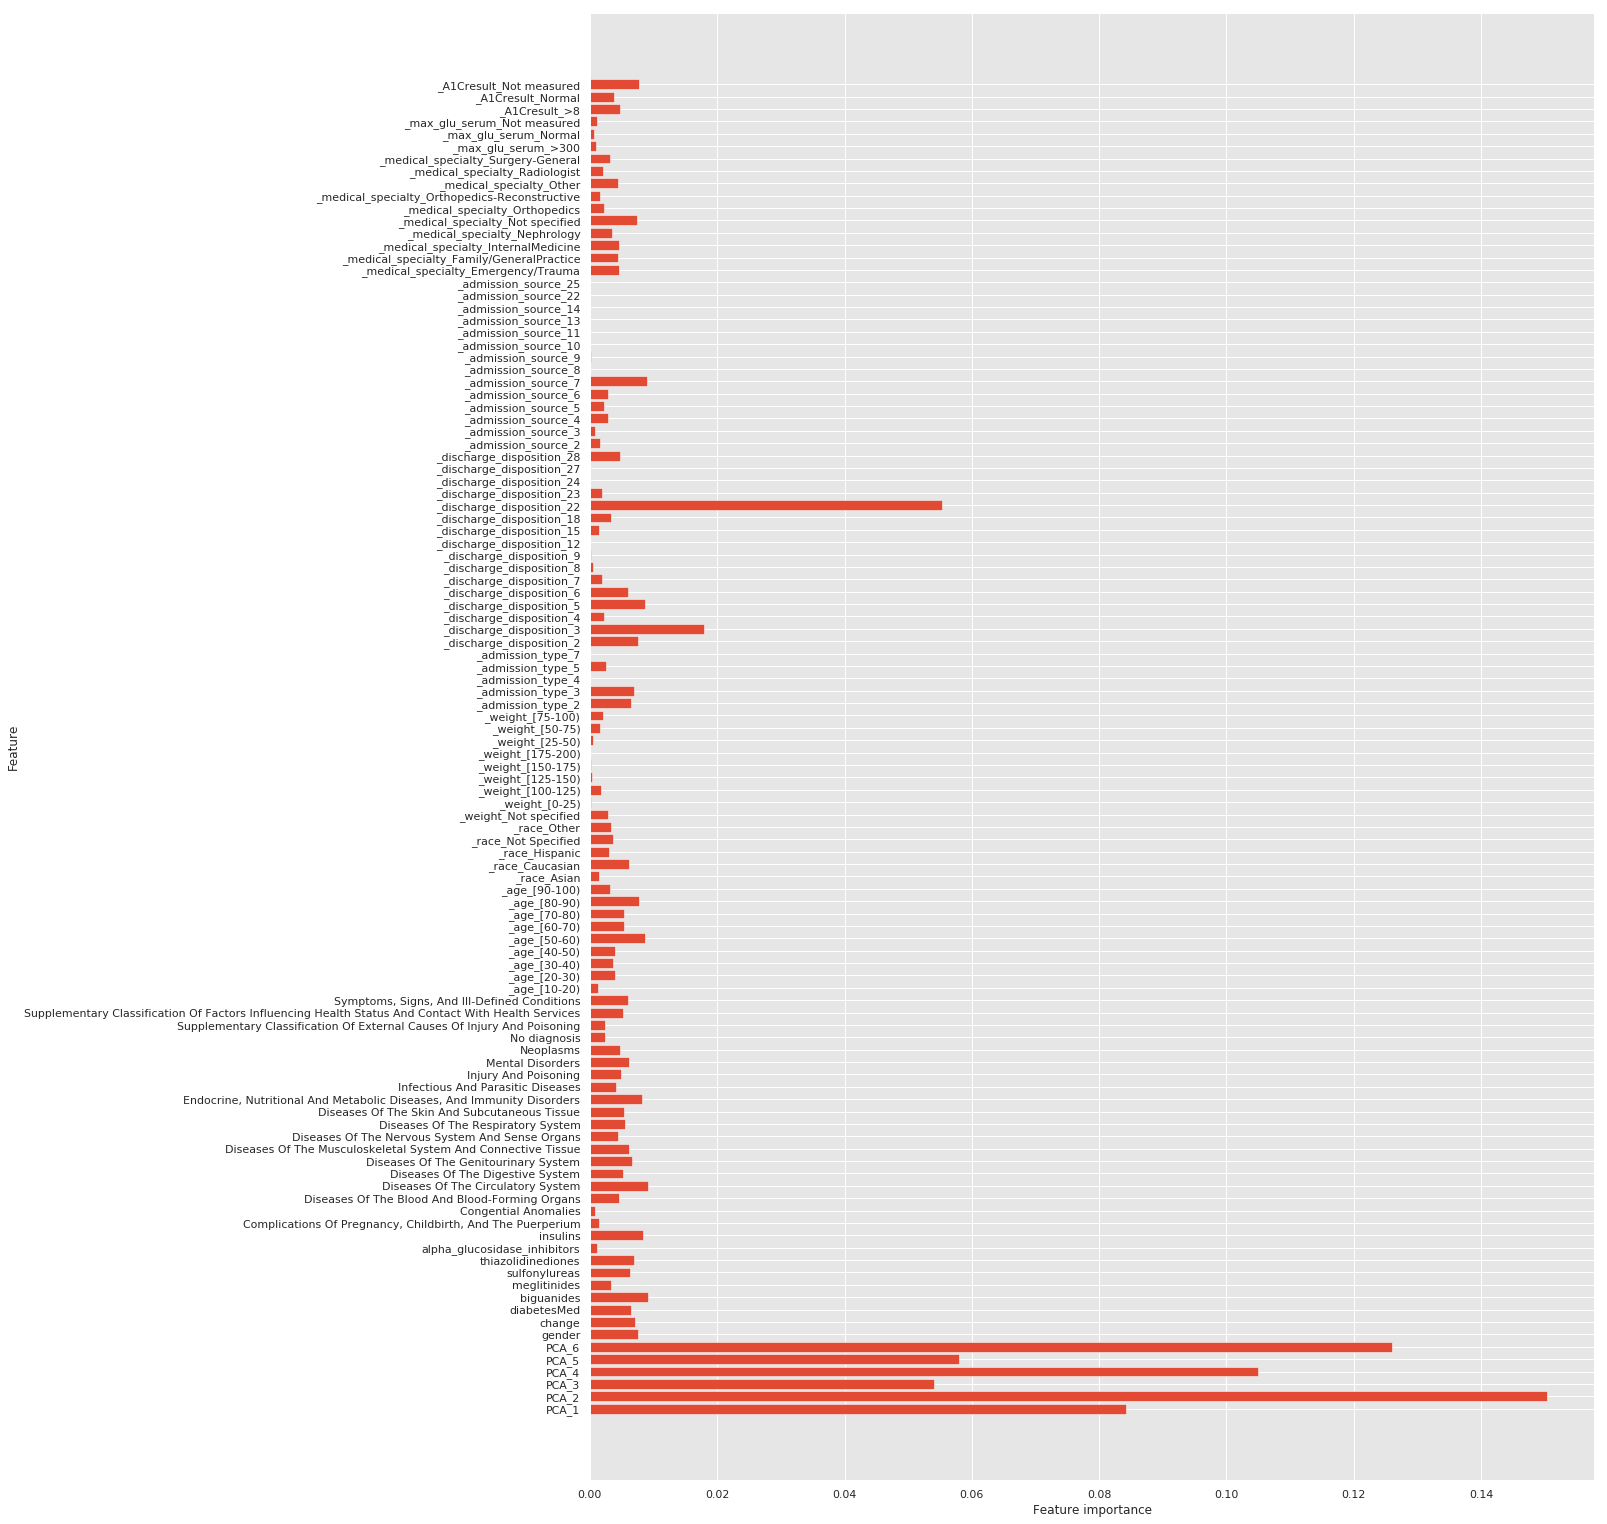

In [91]:
# Plot feature importance

plot_feature_importances(best_rf)

In [92]:
# Confusion Matrix
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_rf = pd.DataFrame(classification_report(y_train, y_train_hat, output_dict = True))
class_rep_rf.rename({'0' : 'y_train', '1' : 'y_train_hat'}, axis = 1, inplace = True)
class_rep_rf

[[1430  615]
 [ 974 1087]]


,y_train,y_train_hat,micro avg,macro avg,weighted avg
f1-score,0.714527,0.663394,0.691062,0.688960,0.688985
precision,0.664643,0.727802,0.691062,0.696223,0.696192
recall,0.772506,0.609459,0.691062,0.690982,0.691062
support,8220.000000,8204.000000,16424.000000,16424.000000,16424.000000


In [93]:
# Classification Report for Testing data

class_rep_rf = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_rf

,0,1,micro avg,macro avg,weighted avg
f1-score,0.642841,0.577731,0.613005,0.610286,0.610159
precision,0.594842,0.638660,0.613005,0.616751,0.616837
recall,0.699267,0.527414,0.613005,0.613340,0.613005
support,2045.000000,2061.000000,4106.000000,4106.000000,4106.000000


In [94]:
print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Test Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))

Training Accuracy for Random Forest Classifier: 69.11%
Test Accuracy for Random Forest Classifier: 61.3%


AUC_test: 0.6554493806861388
AUC_train: 0.7687104741500497


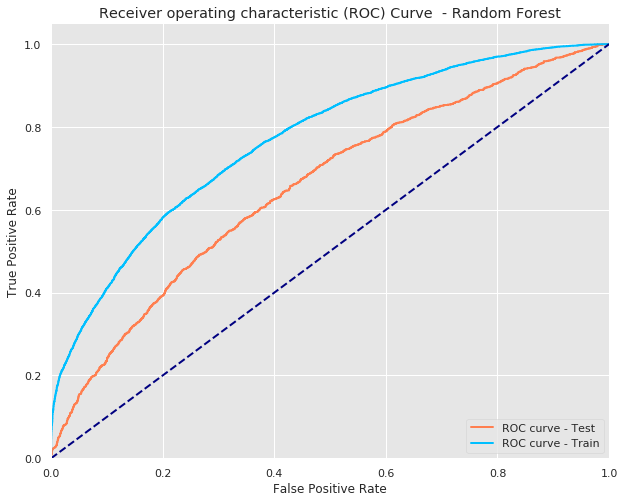

In [95]:
create_roc_auc(best_rf)

### Boosted Trees with XG Boost

In [ ]:
import xgboost as xgb

In [ ]:
clf = xgb.XGBClassifier()

In [ ]:
#Minimum loss reduction required to make a further partition on a leaf node of the tree.

param_grid_rf = {'max_depth': [3],
                 'learning_rate' : [0.16],
                 'gamma' : [7], 
                 'n_estimators': [100]}

In [ ]:
xg_grid = GridSearchCV(clf, param_grid=param_grid_rf, verbose= 10)

In [ ]:
xg_fit = xg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100 ......


In [ ]:
y_train_hat = xg_grid.predict(X_train)

In [ ]:
y_test_hat = xg_grid.predict(X_test)

In [ ]:
print("Training Accuracy for XG Boost Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Test Accuracy for XG Boost Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))

In [ ]:
xg_grid.best_params_

In [ ]:
create_roc_auc(xg_fit)

### SGD - Stochastic gradient descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss = 'modified_huber',penalty="l1", max_iter=600)
sgd.fit(X_train, y_train) 

In [ ]:
print("Training Accuracy for SGD Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Test Accuracy for SGD Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))

In [ ]:
create_roc_auc(sgd)

### Plotting comparison of AUC and accuracy by model

In [ ]:
auc_dict = {'Model': ['Log.Regression - Base','Log.Regression - Base','KNN','KNN','Random Forest','Random Forest',
                      'XGBoost','XGBoost','SGD','SGD'], 
            'AUC': [0.66,0.64,0.62,0.58,0.77,0.66,0.68,0.66, 0.65,0.66],
            'type':['Train','Test','Train','Test','Train','Test','Train','Test','Train','Test']}

# Bar plot
plt.figure(figsize=(12,8))
auc_scores = pd.DataFrame(auc_dict, columns = auc_dict.keys())
ax = sns.barplot(x="Model", y="AUC", hue="type", data=auc_scores, color='deepskyblue')
plt.title('Comparison of AUC by Model',fontsize = 15)
plt.legend(loc="upper right")

In [ ]:
accuracy_dict = {'Model': ['Log.Regression - Base','Log.Regression - Base','KNN','KNN','Random Forest','Random Forest',
                      'XGBoost','XGBoost', 'SGD' , 'SGD'], 
            'Accuracy': [0.62,0.62,0.61,0.59,0.68,0.62,0.63,0.62,0.62,0.62],
            'type': ['Train','Test','Train','Test','Train','Test','Train','Test','Train','Test']}

# Bar plot
plt.figure(figsize=(12,8))
accu_scores = pd.DataFrame(accuracy_dict, columns = accuracy_dict.keys())
ax = sns.barplot(x="Model", y="Accuracy", hue="type", data=accu_scores, color='deepskyblue')
plt.title('Comparison of Accuracy by Model',fontsize = 15)
plt.legend(loc="upper right")
